In [1]:
import numpy as np
from pytorch_tabnet.tab_model import TabNetRegressor


from sklearn.preprocessing import LabelEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt


import pandas as pd

#from distvis import plots as dplot

In [2]:
numerical_features = [
    'edad', 'meses_empleo'
]

categorical_features = [
    'sexo', 'rol_hogar', 'tipo_zona', 
    'termino_nivel', 'cine', 'est_conyugal', 'region', 'comuna', 'provincia',
    'est_subcontratado', 'categoria_empleo', 'grupo_ocupacion', 'nacionalidad'
]

features = categorical_features + numerical_features
target = "sueldo_neto"

In [3]:
datos = pd.read_csv('../datos/datos_procesados.csv').iloc[:, 1:]

test_index = datos.sample(frac=.1, random_state=1313).index
datos['is_test'] = 0 
datos.loc[test_index, 'is_test'] = 1

mean = np.log(datos.query('is_test == 0')[target]).mean()
std = np.log(datos.query('is_test == 0')[target]).std()

def transform(x):
    return (np.log(x) - mean)/std

def inv_transf(x):
    return np.exp(std*x + mean)

datos[target+'_transf'] = transform(datos[target])
datos[target+'_transf'].min(), datos[target+'_transf'].max()

df_train = datos.query('is_test == 0')
df_test = datos.query('is_test == 1')

df_test.loc[:, categorical_features] = df_test.loc[:, categorical_features].astype('category')
df_train.loc[:, categorical_features] = df_train.loc[:, categorical_features].astype('category')

/Users/camiloiturracisternas/miniconda3/envs/spike_basicoV5/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [4]:
def get_categ_index_mapping(df_train, categ_feature):
    base_mapping = dict(zip(df_train[categ_feature], df_train[categ_feature].cat.codes + 1))
    return {**{"N/A": 0}, **base_mapping}

def get_categs_mappings(df_train, categs):
    mappings_list = []
    for i, c in enumerate(categs):
        map_dict = get_categ_index_mapping(df_train, c)
        mappings_list.append({'col': i, 'mapping': map_dict})
    return mappings_list

In [5]:
categs_mappings = get_categs_mappings(df_train, categorical_features)

In [6]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median', fill_value=np.NaN)), 
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value="N/A")),
    ('label', OrdinalEncoder(handle_unknown="value", mapping=categs_mappings)), #uknown values goes to -1
    ('imputer_uknow', SimpleImputer(missing_values=-1, strategy='constant', fill_value=0)), #uknown values go to 0, the index for NaN
    ])

preprocessor = ColumnTransformer(               #preprocessor rearenge columns
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)]
)


preprocessor.fit(df_train[features])

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('cat',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value='N/A',
                                                                missing_values=nan,
                                                                strategy='constant',
                                                                verbose=0)),
                                                 ('label',
                                                  OrdinalEncoder(cols=None,
                                                                 drop_invariant=False,
                   

In [7]:
X_train = preprocessor.transform(df_train[features])
y_train = (df_train[target+'_transf']).values.reshape((-1, 1))

X_test = preprocessor.transform(df_test[features])
y_test = (df_test[target+'_transf']).values.reshape((-1, 1))

In [8]:
def get_emb_size_tio_jeremy(n_cat):
    return min(10, round(1.6 * n_cat**0.56))

In [9]:
cat_dims = [len(categs_mappings[i]['mapping']) for i, feature in enumerate(categorical_features)]
cat_idxs = [i for i, f in enumerate(features) if f in categorical_features]
cat_emb_dim = [get_emb_size_tio_jeremy(n_cat) for n_cat in cat_dims]

In [10]:
cat_emb_dim

[3, 6, 3, 3, 6, 5, 8, 37, 15, 3, 4, 6, 6]

In [12]:
regressor = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

Device used : cpu


In [13]:
max_epochs = 1
regressor.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'test'],
    eval_metric=['mae'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.85606 | train_mae: 0.6429  | test_mae: 0.63711 |  0:00:04s
Stop training because you reached max_epochs = 1 with best_epoch = 0 and best_test_mae = 0.63711
Best weights from best epoch are automatically used!


In [14]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', regressor)])

In [15]:
datos['sueldo_predicho'] = inv_transf(pipeline.predict(datos[features]))
datos['error'] = datos.eval('sueldo_predicho - sueldo_neto')
datos['error_porcentual'] = datos.eval('error/sueldo_neto')
datos['error_porcentual_abs'] = datos.eval('abs(error_porcentual)')

In [16]:
datos.query('is_test == 1')['error_porcentual_abs'].mean()

0.7029747711401189

In [17]:
datos.query('is_test == 1')['error_porcentual_abs'].median()

0.3516298762242538

<AxesSubplot:>

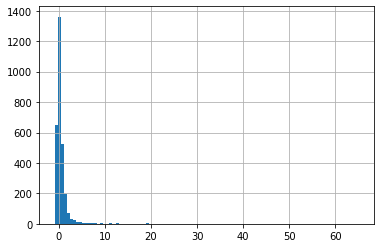

In [18]:
datos.query('is_test == 1')['error_porcentual'].hist(bins=100)

<AxesSubplot:>

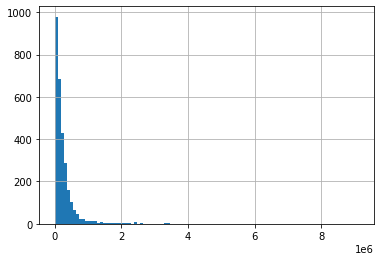

In [19]:
abs(datos.query('is_test == 1')['error']).hist(bins=100)

<AxesSubplot:>

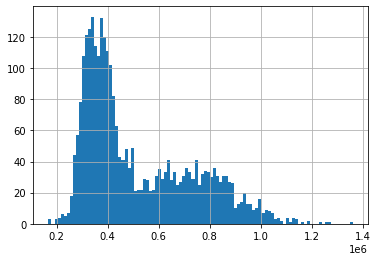

In [20]:
datos.query('is_test == 1')['sueldo_predicho'].hist(bins=100)

# Análisis contrafactual de fairness

- Feature sensible $s$ y el resto de features $x$. Ejemplo: $s=$ sexo 
- El feature $s$ está particionado en un conjunto de personas desprotegidas $D$ y otro conjunto de personas privilegiadas $P$. Ejemplo: para $s=$ sexo, $D=$ {Mujer} y $P=$ {Hombre}
- Para un modelo predictivo $F$ y una persona con features no sensibles $x$ definimos para $s_d \in D$  y $s_p \in P$ la métrica de fairness que mide cuanto más porcentualmente ganaría la persona $(x, s_p)$ por sobre $(x, s_d)$, es decir:
$$\phi(x, s_p, s_d) = \frac{F(x, s_p)-F(x, s_d)}{F(x, s_d)}$$
- Luego para cada persona en los datos $z_i = (x_i, s_i)$ promediamos todos las posibles comparaciones contrafactuales definidas en el punto anterior, es decir:
$$\frac{1}{|D||P|}\sum_{s_p \in P, s_d \in P}\phi(x, s_p, s_d)$$


In [21]:
regiones_privilegiadas = ['Metropolitana de Santiago', 'Atacama', 'Aysén del General Carlos Ibáñez del Campo',
                          'Tarapacá', 'Magallanes y de la Antártica Chilena', 'Antofagasta']

In [22]:
dict_particion = {
    'sexo': {
        'desprotegido': ['Mujer'],
        'privilegiado': ['Hombre'],
    }
    ,
    
    'region': {
        'desprotegido':  [v for v in datos['region'].unique() if not v in regiones_privilegiadas],
        'privilegiado':  regiones_privilegiadas,
    }   
}

dict_sample_frac = {
    'sexo': 1, 'region': 0.01
}

In [23]:
from itertools import product

In [24]:
def diferencia_porcentual(df, feature):
    desprotegidos = dict_particion[feature]['desprotegido']
    privilegiados = dict_particion[feature]['privilegiado']
    combinaciones = [list(par) for par in product(desprotegidos, privilegiados)]
    sueldos = df.set_index(feature)[['sueldo_predicho']]
    valores = np.array([sueldos.loc[comb, 'sueldo_predicho'].values for comb in combinaciones])
    
    return ((valores[:, 1] - valores[:, 0])/valores[:, 0]).mean() #sueldos[combinaciones[0]]


diff_pct_dict = {}

for feature, particion in dict_particion.items():
    print(feature)

    valores = particion['privilegiado'] + particion['desprotegido']
    otros_features = [f for f in features if f != feature]
    datos_contraf = datos[otros_features].sample(frac=dict_sample_frac[feature], random_state=1313).copy()
    datos_contraf['dummy'] = 1
    datos_contraf['id_persona'] = datos_contraf.index
    valores_df = pd.DataFrame({feature: valores, 'dummy': 1})
    datos_contraf = pd.merge(datos_contraf, valores_df, on='dummy')
    datos_contraf['sueldo_predicho'] = inv_transf(pipeline.predict(datos_contraf[features]))
    diff_pct = datos_contraf.groupby('id_persona').apply(diferencia_porcentual, feature=feature)
    diff_pct_dict[feature] = diff_pct
    datos = pd.merge(datos, diff_pct.to_frame(f'diff_pct_{feature}'), 
                     left_index=True, right_index=True,
                     how='left')
    del datos_contraf
    
    
var = 'sexo'
print(diff_pct_dict[var].mean())
print(diff_pct_dict[var].median())
diff_pct_dict[var].hist(bins=40)

var = 'region'
print(diff_pct_dict[var].mean())
diff_pct_dict[var].hist(bins=40)

In [25]:
m_h = datos.query('sexo == "Hombre"').sueldo_neto.median()
m_m = datos.query('sexo == "Mujer"').sueldo_neto.median()
round(100 * (m_h - m_m)/m_m)

19

# BNN

In [26]:
import pyro
import pyro.distributions as dist
from pyro import poutine

from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, TracePredictive
from pyro.optim import Adam
from pyro.infer import EmpiricalMarginal
from pyro.infer import Predictive
import torch

In [27]:
def get_predictions_pyro(model, guide, df, n_samples=25, varbls=['_RETURN']):
    
    x = torch.Tensor(preprocessor.transform(df[features]))
    
    predictive = Predictive(model, guide=guide, num_samples=n_samples, return_sites=varbls)
    samples_post = {v: predictive(x, None)[v].cpu().detach().numpy() for v in varbls}
    
    return samples_post


In [28]:
bayesian_weights = [name for name, _ in regressor.network.named_parameters() if'fc' in name or 'final' in name]
bayesian_weights

['tabnet.encoder.initial_splitter.specifics.glu_layers.0.fc.weight',
 'tabnet.encoder.initial_splitter.specifics.glu_layers.1.fc.weight',
 'tabnet.encoder.feat_transformers.0.specifics.glu_layers.0.fc.weight',
 'tabnet.encoder.feat_transformers.0.specifics.glu_layers.1.fc.weight',
 'tabnet.encoder.feat_transformers.1.specifics.glu_layers.0.fc.weight',
 'tabnet.encoder.feat_transformers.1.specifics.glu_layers.1.fc.weight',
 'tabnet.encoder.feat_transformers.2.specifics.glu_layers.0.fc.weight',
 'tabnet.encoder.feat_transformers.2.specifics.glu_layers.1.fc.weight',
 'tabnet.encoder.att_transformers.0.fc.weight',
 'tabnet.encoder.att_transformers.1.fc.weight',
 'tabnet.encoder.att_transformers.2.fc.weight',
 'tabnet.final_mapping.weight']

In [29]:
device = regressor.device

In [30]:
one = torch.ones(1).to(device)
zero = torch.ones(1).to(device)

In [31]:
net = regressor.network
bayesian_weights = [name for name, _ in regressor.network.named_parameters() if 'final' in name]
weights = {name: values.data for name, values in regressor.network.named_parameters() if name in bayesian_weights}
bayesian_weights

['tabnet.final_mapping.weight']

In [32]:
batch_size = 1000
scale = 0.001

tabnet_centered = True

#original
def model(x, y=None):
    
    #define priors
    priors = {}
    for name, values in weights.items():
        if tabnet_centered:
            loc = values
        else:
            loc = torch.zeros_like(values)
            
        priors[name] = dist.Normal(loc=loc, 
                                   scale=scale*torch.ones_like(values))
    
    #return net(x)
    lifted_module = pyro.random_module("module", net, priors)
    lifted_module_sample = lifted_module()
    
    preds = lifted_module_sample(x)[0].squeeze()
    
    sigma = 1e-2*one#pyro.sample('sigma', dist.Uniform(one*1e-1, one))
    
    #likelihood:
    if y is not None:
        with pyro.plate('observe_data', size=len(y), subsample_size=batch_size, device=device) as ind:
            pyro.sample('obs', dist.Normal(preds.index_select(0, ind), sigma), 
                        obs=y.index_select(0, ind))
    
    return preds


In [62]:
regressor.network(torch.Tensor(X_test))

(tensor([[-0.1413],
         [ 0.5187],
         [-0.3246],
         ...,
         [ 0.9947],
         [ 1.0069],
         [-0.4334]], grad_fn=<MmBackward>),
 tensor(-0.7667, grad_fn=<DivBackward0>))

In [63]:
regressor.predict(X_test)

array([[-0.14132501],
       [ 0.5187208 ],
       [-0.3245775 ],
       ...,
       [ 0.9947125 ],
       [ 1.0068719 ],
       [-0.43338856]], dtype=float32)

In [68]:
model(torch.Tensor(X_test))

tensor([-0.1405,  0.5176, -0.3254,  ...,  0.9942,  1.0050, -0.4329],
       grad_fn=<SqueezeBackward0>)

In [69]:
guide = AutoDiagonalNormal(model)

In [70]:
optim = Adam({"lr": 0.03})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=1000)

/Users/camiloiturracisternas/miniconda3/envs/spike_basicoV5/lib/python3.6/site-packages/pyro/infer/svi.py:53: FutureWarning: The `num_samples` argument to SVI is deprecated and will be removed in a future release. Use `pyro.infer.Predictive` class to draw samples from the posterior.
  'samples from the posterior.', FutureWarning)


In [36]:
X_train_torch = torch.Tensor(X_train)
y_train_torch = torch.Tensor(y_train)

In [72]:
pyro.clear_param_store()
num_iterations = 20
loss_list = []

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(X_train_torch, y_train_torch)
    loss_list += [loss]
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss))

[iteration 0001] loss: 181383749051.7068


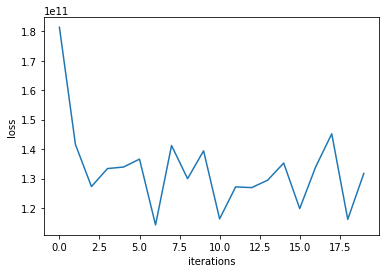

In [73]:
iter_min = 0
plt.plot(np.array(loss_list[iter_min:]))
plt.xlabel('iterations')
plt.ylabel('loss');

In [74]:
valid_post = get_predictions_pyro(model, guide, df_test, n_samples=100)['_RETURN']


/Users/camiloiturracisternas/miniconda3/envs/spike_basicoV5/lib/python3.6/site-packages/pyro/primitives.py:371: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


In [ ]:
model(X_train_torch)

In [33]:
from pyro.infer.mcmc import HMC
from pyro.infer import MCMC

In [34]:
my_kernel = HMC(model)
my_mcmc = MCMC(my_kernel,
               num_samples=20000,
               warmup_steps=100)

In [37]:
my_mcmc.run(X_train_torch, y_train_torch)


Warmup:   0%|          | 0/20100 [00:00, ?it/s]/Users/camiloiturracisternas/miniconda3/envs/spike_basicoV5/lib/python3.6/site-packages/pyro/primitives.py:371: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


KeyboardInterrupt: 